In [13]:
import matplotlib
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.use('pgf')

import pandas as pd

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt

import seaborn as sns

sns.set(font="serif")

from scipy.stats import bartlett

import IPython

from matplotlib2tikz import save as tikz_save

%matplotlib inline

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [14]:
def print_pgfplot(data, out_file="tukey.tex"):
    with open(out_file, "w") as f:
        f.write("\\documentclass{standalone}")
        f.write("\\usepackage{pgfplots}")
        f.write("\\pgfplotsset{compat=newest}")
        f.write("\\usepgfplotslibrary{colorbrewer}\n")
        f.write("\\begin{document}")
        f.write("\\footnotesize")
        f.write("\\begin{tikzpicture}")
        f.write("\\definecolor{color0}{rgb}{0.917647058823529,0.917647058823529,0.949019607843137}")
        f.write("\\begin{axis}[stack plots=y, stack dir=minus,")
        f.write("width=.7\\linewidth,")
        
        if data.shape[1] < 8:
            height = "{0}cm".format(0.7*data.shape[1]+1)
        else:
            height = ".7\\linewidth"
        
        f.write("height={0},".format(height))
        f.write("xmajorgrids=true,")
        f.write("xminorgrids=true,")
        f.write("minor x tick num=1,")
        f.write("axis background/.style={fill=color0},")
        f.write("axis line style={white},")
        f.write("every tick/.style={white},")
        f.write("ymajorgrids=true,\n")
        f.write("every major grid/.style={white},")
        f.write("every minor grid/.style={white},")
        f.write("cycle multi list={Dark2-8},\n")
        f.write("ytick={{{0}}},".format(", ".join([str(-i) for i in range(1, data.shape[1]+1)])))
        f.write("yticklabels={{{0}}}".format(", ".join([col.replace("_", " ") for col in data])))
        f.write("]")
    
        for col in data:
            f.write("\\addplot+[mark=*, solid, thick, error bars/.cd,x dir=both,x explicit] coordinates {")
            f.write("({0},1) +- ({1},{1})".format(data[col]["mean"], data[col]["halfwidth"]))
            f.write("};")
        f.write("\\end{axis}")
        f.write("\\end{tikzpicture}")
        f.write("\\end{document}")

In [26]:
def print_pgfplot_boxplot(data, out_file="boxplot.tex"):
    with open(out_file, "w") as f:
        f.write("\\documentclass{standalone}\n")
        f.write("\\usepackage{pgfplots}\n")
        f.write("\\pgfplotsset{compat=newest}\n")
        f.write("\\usepgfplotslibrary{statistics}\n")
        f.write("\\usepgfplotslibrary{colorbrewer}\n")
        f.write("\\begin{document}\n")
        f.write("\\footnotesize\n")
        f.write("\\begin{tikzpicture}\n")
        f.write("\\definecolor{color0}{rgb}{0.917647058823529,0.917647058823529,0.949019607843137}")
        f.write("\\begin{axis}[boxplot/draw direction=x,\n"\
                "axis background/.style={fill=color0},"\
                "every tick/.style={white},"\
                "xmajorgrids=true,\n"\
                "ymajorgrids=true,\n"\
                "xminorgrids=true,\n"\
                "minor x tick num=1,\n"\
                "axis line style={white},"\
                "every major grid/.style={white},\n"\
                "every minor grid/.style={white},\n"\
                "cycle multi list={Dark2-8},\n")
        f.write("ytick={{{0}}},\n".format(", ".join([str(-i) for i in range(1, data.shape[1]+1)])))
        f.write("yticklabels={{{0}}}\n".format(", ".join([col.replace("_", " ") for col in data])))
        f.write("]\n")
            
        for i, col in enumerate(data):
            f.write("\\addplot+[boxplot={")
            f.write("draw position={0}".format(-i-1))
            f.write("}] table[row sep=\\\\,y index=0]")
            f.write("{\n")
            f.write("{0}\\\\".format(col))
            f.write("\\\\ ".join([str(val) for val in data[col]]))
            f.write("\\\\".format(col))
            f.write("};\n")
        f.write("\\end{axis}\n")
        f.write("\\end{tikzpicture}\n")
        f.write("\\end{document}\n")

In [27]:
def collect_results(iter_num, networks, metric="CLA"):
    N_SIM = 10


    matrix = []
    for network in networks:
        row = []
        for i in range(N_SIM):
            data_sim = pd.read_csv("results_of_simulation/shift_sim_data/"\
                                   "data_{0}_to_clique_{1}{2}".format(network, metric, i),
                                   delim_whitespace=True, header=None, index_col=0)
            row.append(data_sim.loc[iter_num].mean())
        matrix.append(row)

    results = pd.DataFrame(matrix)
    results.columns = list(range(N_SIM))
    
    names = []
    for n in networks:
        if n == "hub":
            names.append("star balanced")
        elif n == "hub_speaker":
            names.append("star hearer")
        elif n == "hub_hearer":
            names.append("star speaker")
        elif n == "clique":
            names.append("fully connected")
        else:
            names.append(n.replace("_", " "))
    
    results.index = names

    return results

In [28]:
def collect_results_env(iter_num, networks, metric="CLA"):
    N_SIM = 10


    matrix = []
    for network in networks:
        row = []
        for i in range(N_SIM):
            data_sim = pd.read_csv("results_of_simulation/env_shift_gauss_sim_data/"\
                                   "data_env_training{0}{1}_{2}".format(network, metric, i),
                                   delim_whitespace=True, header=None, index_col=0)
            row.append(data_sim.loc[iter_num].mean())
        matrix.append(row)

    results = pd.DataFrame(matrix)
    results.columns = list(range(N_SIM))
    
    names = []
    for n in networks:
        if n == "hub":
            names.append("star balanced")
        elif n == "hub_speaker":
            names.append("star hearer")
        elif n == "hub_hearer":
            names.append("star speaker")
        elif n == "clique":
            names.append("fully connected")
        else:
            names.append(n.replace("_", " "))
    
    results.index = names
    
    return results

In [29]:
def bartlett_anova_tukey_suite(r):
    plt.figure(figsize=(18,10))
    sns.violinplot(data=r)   
    print(bartlett(*[r[col] for col in r]))
    
    r1 = pd.melt(r)

    lm = ols("value~variable", r1).fit()
    alm = anova_lm(lm)
    IPython.display.display(alm)
    
    comp_res = pairwise_tukeyhsd(r1["value"], r1["variable"])
    comp_res.plot_simultaneous()
    #plt.savefig("tukey_fig.pgf")
    IPython.display.display(comp_res.summary())
    
    means = r.mean()
    halfwidths = pd.Series(comp_res.halfwidths)
    halfwidths.index = means.index
    
    res = pd.DataFrame([means, halfwidths])
    res.index = ["mean", "halfwidth"]
    
    return res

## Mason topologies 10000

BartlettResult(statistic=8.7681567256614859, pvalue=0.36223002474470523)


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


,df,sum_sq,mean_sq,F,PR(>F)
variable,8,1.255315,0.156914,180.244643,2.704742e-48
Residual,81,0.070516,0.000871,NaN,NaN


group1,group2,meandiff,lower,upper,reject
fully connected,max avg bet,-0.402,-0.4441,-0.3599,True
fully connected,max avg clust,-0.3672,-0.4093,-0.3252,True
fully connected,max max bet,-0.374,-0.4161,-0.3319,True
fully connected,max max clos,-0.2587,-0.3008,-0.2167,True
fully connected,max var cons,-0.2976,-0.3397,-0.2556,True
fully connected,min avg bet,-0.2176,-0.2597,-0.1756,True
fully connected,min avg clust,-0.2254,-0.2674,-0.1833,True
fully connected,min max clos,-0.3704,-0.4124,-0.3283,True
max avg bet,max avg clust,0.0347,-0.0073,0.0768,False
max avg bet,max max bet,0.028,-0.0141,0.0701,False


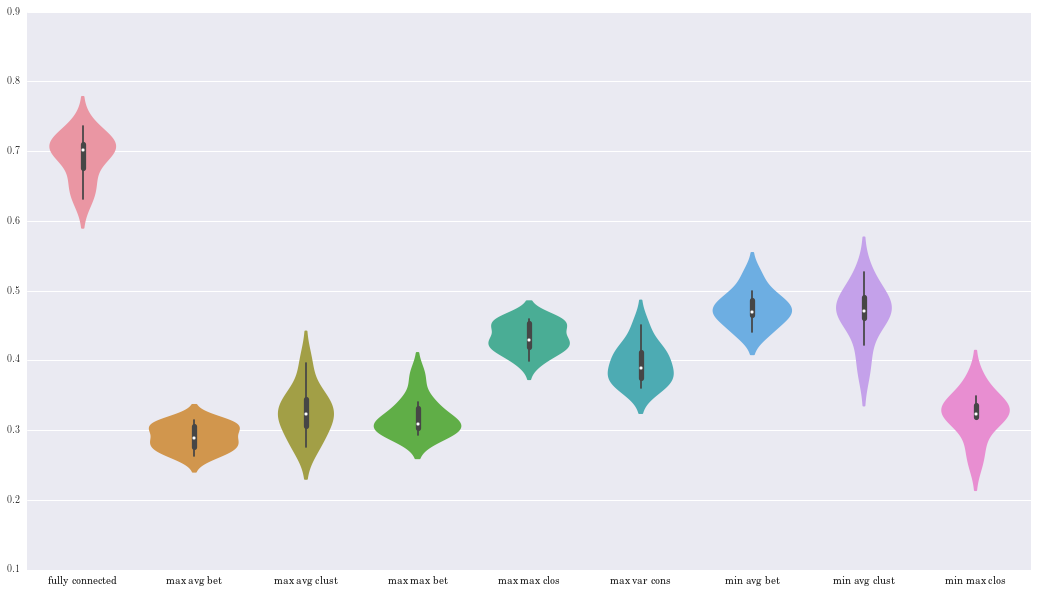

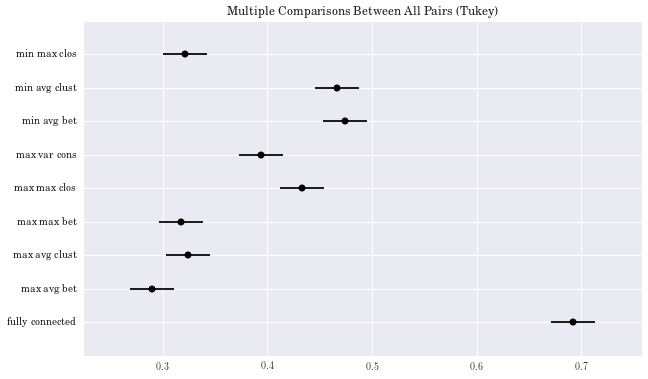

In [30]:
networks = ["clique",
    "max_avg_bet", "max_avg_clust", "max_max_bet", "max_max_clos",
            "max_var_cons", "min_avg_bet", "min_avg_clust", "min_max_clos",
            
            # "hub", "clique", "hub_hearer", "hub_speaker"
           ]

r = collect_results(10000, networks).T
res = bartlett_anova_tukey_suite(r)
print_pgfplot(res, "manuscript_plots/tukey_mason.tex")

## Hub 10000

BartlettResult(statistic=4.4672304550814284, pvalue=0.21523194696624726)


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


,df,sum_sq,mean_sq,F,PR(>F)
variable,3,1.210115,0.403372,228.974943,1.691411e-23
Residual,36,0.063419,0.001762,NaN,NaN


group1,group2,meandiff,lower,upper,reject
fully connected,star balanced,-0.1934,-0.2439,-0.1428,True
fully connected,star hearer,-0.4406,-0.4912,-0.3901,True
fully connected,star speaker,-0.0345,-0.0851,0.0161,False
star balanced,star hearer,-0.2472,-0.2978,-0.1967,True
star balanced,star speaker,0.1589,0.1083,0.2094,True
star hearer,star speaker,0.4061,0.3556,0.4567,True


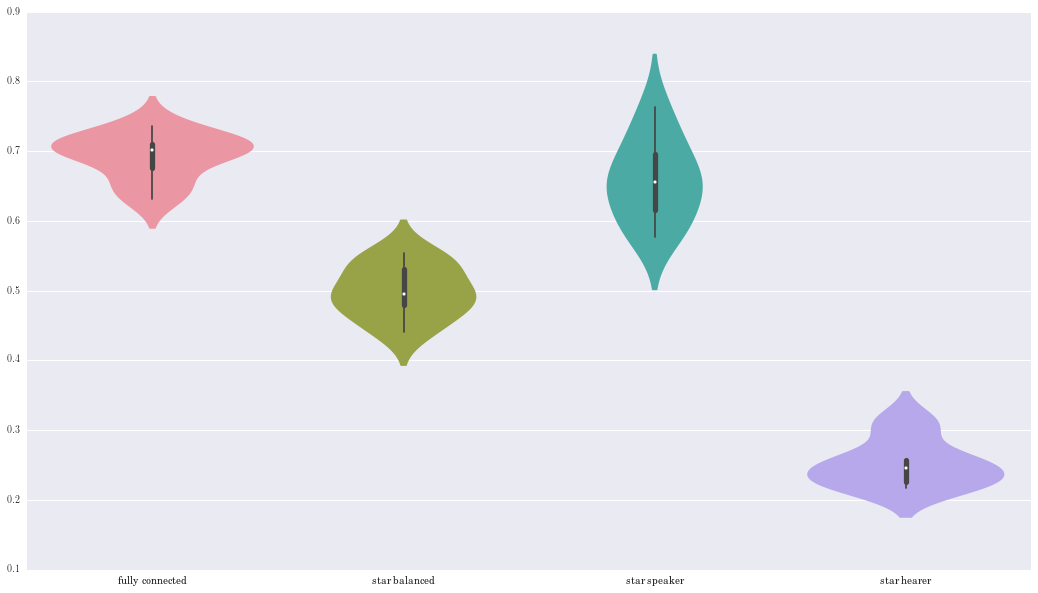

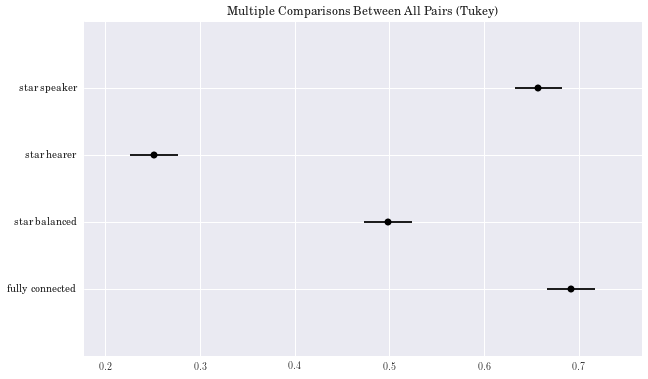

In [31]:
networks = ["clique",
            "hub", 
            "hub_hearer",
            "hub_speaker"
           ]

r = collect_results(10000, networks).T
res = bartlett_anova_tukey_suite(r)
print_pgfplot(res, "manuscript_plots/tukey_hub_1.tex")

## Hub 20000

BartlettResult(statistic=1.1965470052710807, pvalue=0.75383260105067684)


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


,df,sum_sq,mean_sq,F,PR(>F)
variable,3,0.053156,0.017719,14.909957,0.000002
Residual,36,0.042781,0.001188,NaN,NaN


group1,group2,meandiff,lower,upper,reject
fully connected,star balanced,-0.0366,-0.0781,0.0049,False
fully connected,star hearer,-0.0315,-0.073,0.01,False
fully connected,star speaker,0.055,0.0135,0.0965,True
star balanced,star hearer,0.0051,-0.0364,0.0466,False
star balanced,star speaker,0.0916,0.0501,0.1331,True
star hearer,star speaker,0.0865,0.045,0.128,True


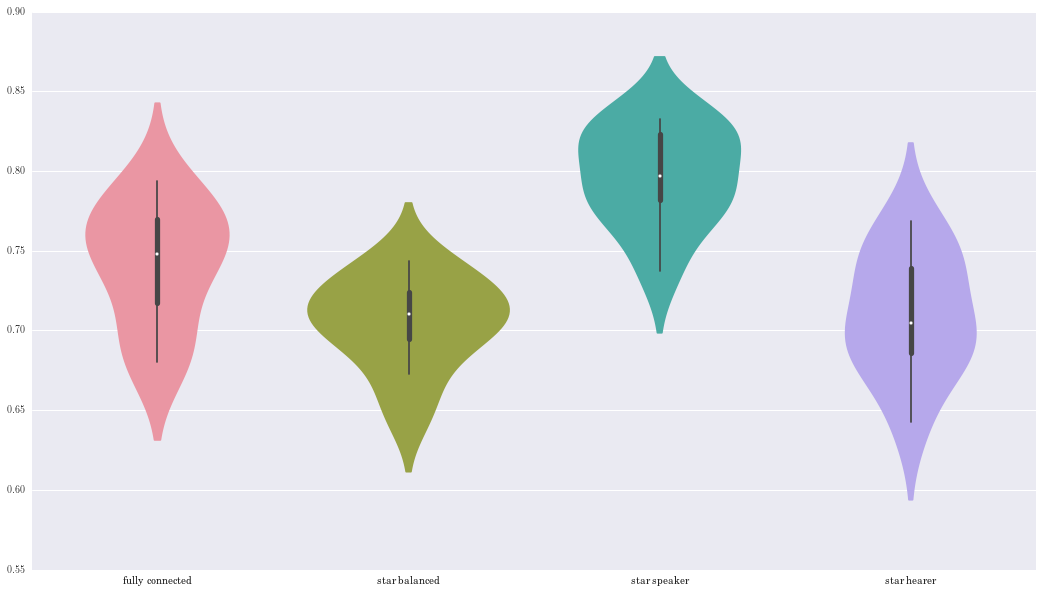

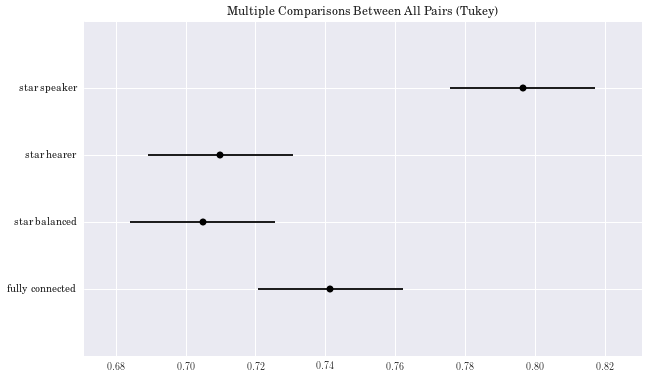

In [32]:
networks = ["clique",
            "hub",
            "hub_hearer",
            "hub_speaker"
           ]

r = collect_results(20000, networks).T
res = bartlett_anova_tukey_suite(r)
print_pgfplot(res, "manuscript_plots/tukey_hub_2.tex")

## Environment shift

BartlettResult(statistic=42.787491996557982, pvalue=1.1825855921821369e-05)


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


,df,sum_sq,mean_sq,F,PR(>F)
variable,11,0.182303,0.016573,12.980231,2.202142e-15
Residual,108,0.137893,0.001277,NaN,NaN


group1,group2,meandiff,lower,upper,reject
fully connected,max avg bet,0.0725,0.0191,0.1259,True
fully connected,max avg clust,0.0968,0.0434,0.1501,True
fully connected,max max bet,0.0749,0.0215,0.1283,True
fully connected,max max clos,0.0701,0.0167,0.1235,True
fully connected,max var cons,0.0623,0.0089,0.1156,True
fully connected,min avg bet,0.0663,0.0129,0.1196,True
fully connected,min avg clust,0.07,0.0166,0.1234,True
fully connected,min max clos,0.0739,0.0205,0.1273,True
fully connected,star balanced,0.0004,-0.053,0.0538,False
fully connected,star hearer,0.1051,0.0517,0.1585,True


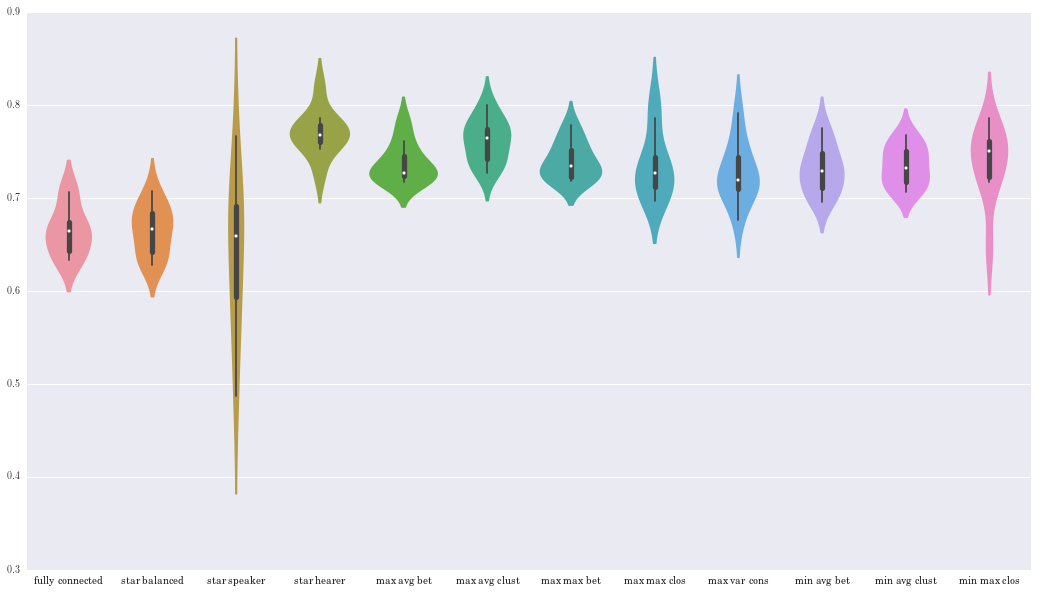

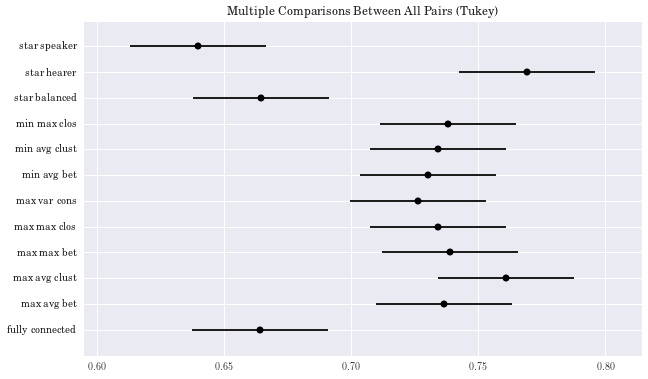

In [33]:
networks = ["clique",
            "hub",
            "hub_hearer",
            "hub_speaker",
            "max_avg_bet", "max_avg_clust", "max_max_bet", "max_max_clos",
            "max_var_cons", "min_avg_bet", "min_avg_clust", "min_max_clos"
           ]

r = collect_results_env(20000, networks, metric="CSA").T
print_pgfplot_boxplot(r, "manuscript_plots/env_shift_gauss_boxplot.tex")

res = bartlett_anova_tukey_suite(r)
print_pgfplot(res, "manuscript_plots/tukey_env.tex")

# Color histograms

In [34]:
import json
import pandas as pd

In [35]:
with open("examples/environment/600_munsell_chips_gauss_1.json") as f:
    env_a = pd.DataFrame(json.load(f)['stimuli'])
with open("examples/environment/600_munsell_chips_gauss_2.json") as f:
    env_b = pd.DataFrame(json.load(f)['stimuli'])

file encoding: UTF-8
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec}
\usepackage{pgfplots}
\usepgfplotslibrary{groupplots}


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


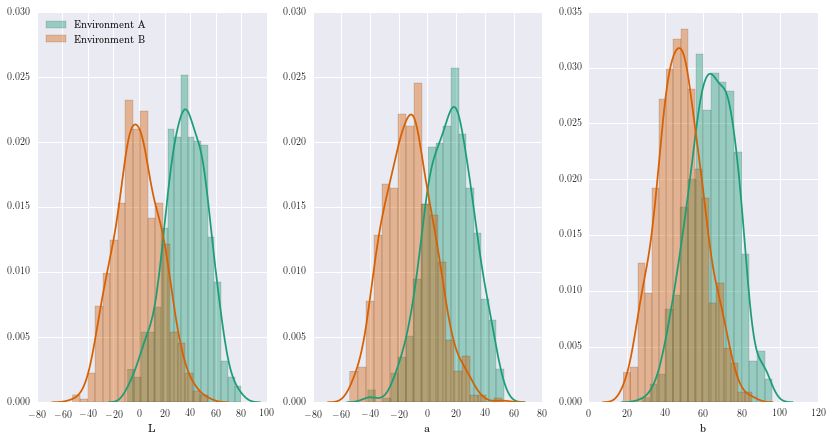

In [36]:
sns.set_palette(sns.color_palette("Dark2", 2))

plt.figure(figsize=(14,7))

plt.subplot(1, 3, 1)
sns.distplot(env_a["L"], label="Environment A")
sns.distplot(env_b["L"], label="Environment B")
plt.legend(loc='upper left')

plt.subplot(1, 3, 2)
sns.distplot(env_a["a"])
sns.distplot(env_b["a"])

plt.subplot(1, 3, 3)
sns.distplot(env_a["b"])
sns.distplot(env_b["b"])

tikz_save("manuscript_plots/env_a_b_hist.tikz")